# ResNet34 with MNIST

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
from tqdm.notebook import tqdm
from torch import nn 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 256
ce_loss = nn.CrossEntropyLoss()
learning_rate = 0.01
weight_decay = 0.001
momentum = 0.9
epoch = 10

## MNIST Dataset

In [3]:
# Download traning and test data from open datasets --- MNIST
def mnist():
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )

    num_classes = 10
    return training_data, test_data, num_classes

In [4]:
#gpu 
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using {} device \n".format(device))

# Dataloader
training_data, test_data, NUM_CLASSES = mnist()
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Using cuda device 



## Model

In [5]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = None
        if stride != 1:
            self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2)
        

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.conv3 != None:
            identity = self.conv3(identity)
        out += identity
        out = self.relu2(out)

        return out

In [6]:

# ResNet model
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=1, bias=False)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_blocks = nn.ModuleList()

        in_channels = out_channels = 64
        for _ in range(3):
            self.residual_blocks.append(ResidualBlock(in_channels, out_channels))

        in_channels = out_channels = 128
        self.residual_blocks.append(ResidualBlock(int(in_channels/2), out_channels, stride=2))
        for _ in range(3):
            self.residual_blocks.append(ResidualBlock(in_channels, out_channels))

        in_channels, out_channels = 256, 256
        self.residual_blocks.append(ResidualBlock(int(in_channels/2), out_channels, stride=2))
        for _ in range(5):
            self.residual_blocks.append(ResidualBlock(in_channels, out_channels))

        in_channels, out_channels = 512, 512
        self.residual_blocks.append(ResidualBlock(int(in_channels/2), out_channels, stride=2))
        for _ in range(2):
            self.residual_blocks.append(ResidualBlock(in_channels, out_channels))

        #self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)        # using interpolation
        self.avg_pool = nn.AvgPool2d(kernel_size=1, stride=1)         # using padding
        self.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES)             # change the in_features here
        # self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        out = x.to(device)
        # out = nn.functional.interpolate(out, size=227, mode='nearest-exact')          # using interpolation
        padding = nn.ZeroPad2d((0, 7, 0, 7))                                            # using padding 
        out = padding(out)
        out = self.conv0(out)
        out = self.max_pool(out)
        for i in range(len(self.residual_blocks)):
            out = self.residual_blocks[i](out)

        out = self.avg_pool(out)
        out = out.view(out.shape[0], -1)
        # out = self.flatten(out)
        out = self.fc(out)
        # out = self.softmax(out) # it is included in the ce loss fn
        return out

In [7]:
model = ResNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

In [8]:
# Accuracy 
def accuracy(y_pred, target):
    train_acc = torch.sum(torch.argmax(y_pred, dim=1) == target)
    final_train_acc = train_acc/target.shape[0]
    return final_train_acc * 100

In [9]:
all_train_losses=[]
all_test_losses=[]
all_train_accuracy=[]
all_test_accuracy=[]

In [10]:
def train():
    cur_step = 0
    for features, label in train_dataloader:
        logits = model(features)
        label = label.to(device)

        loss = ce_loss(logits, label)
        accuracy_batch = accuracy(logits, label)
        all_train_losses.append(loss.item())
        all_train_accuracy.append(accuracy_batch.item())

        optimizer.zero_grad()
        loss.backward()
        if cur_step % 100 == 0:
           print('\033[32m' + f"Step = {cur_step}, Train Loss = {loss:.3f}, Train Accuracy = {accuracy_batch:.2f}%" + '\033[0m')
        optimizer.step()
        cur_step += 1

In [11]:
def test():
    model.eval()
    total_loss = 0
    total_accuracy = 0
    step = 0
    
    for features, label in test_dataloader:
        with torch.no_grad():
            logits = model(features)
            label = label.to(device)
            loss = ce_loss(logits, label)
            total_loss += loss.item()
            accuracy_batch = accuracy(logits, label)
            total_accuracy += accuracy_batch.item()
            step += 1
    total_loss = total_loss / step
    total_accuracy = total_accuracy /step

    all_test_losses.append(total_loss)
    all_test_accuracy.append(total_accuracy)
    print('\033[31m' + f"Test Loss = {total_loss:.3f}, Test Accuracy = {total_accuracy:.2f}%" + '\033[0m')
    model.train()
    return total_loss

In [12]:
for i in tqdm(range(epoch)):
    print()
    print('\033[34m' + f"Epoch {i+1}" + '\033[0m')
    train()
    test_loss = test()
    scheduler.step(test_loss)
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1
Step = 0, Train Loss = 2.707, Train Accuracy = 8.20%
Step = 100, Train Loss = 0.139, Train Accuracy = 96.09%
Step = 200, Train Loss = 0.086, Train Accuracy = 97.27%
Test Loss = 0.124, Test Accuracy = 96.28%
Learning Rate = 0.01

Epoch 2
Step = 0, Train Loss = 0.122, Train Accuracy = 95.70%
Step = 100, Train Loss = 0.067, Train Accuracy = 97.66%
Step = 200, Train Loss = 0.053, Train Accuracy = 98.44%
Test Loss = 0.062, Test Accuracy = 98.12%
Learning Rate = 0.01

Epoch 3
Step = 0, Train Loss = 0.101, Train Accuracy = 97.66%
Step = 100, Train Loss = 0.062, Train Accuracy = 98.05%
Step = 200, Train Loss = 0.037, Train Accuracy = 99.22%
Test Loss = 0.060, Test Accuracy = 98.12%
Learning Rate = 0.01

Epoch 4
Step = 0, Train Loss = 0.073, Train Accuracy = 97.66%
Step = 100, Train Loss = 0.034, Train Accuracy = 98.83%
Step = 200, Train Loss = 0.055, Train Accuracy = 98.44%
Test Loss = 0.049, Test Accuracy = 98.50%
Learning Rate = 0.01

Epoch 5
Step = 0, Train Loss = 0.042, Train Accu

In [13]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

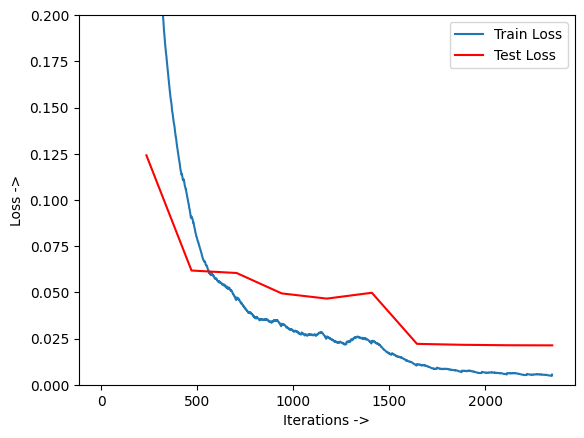

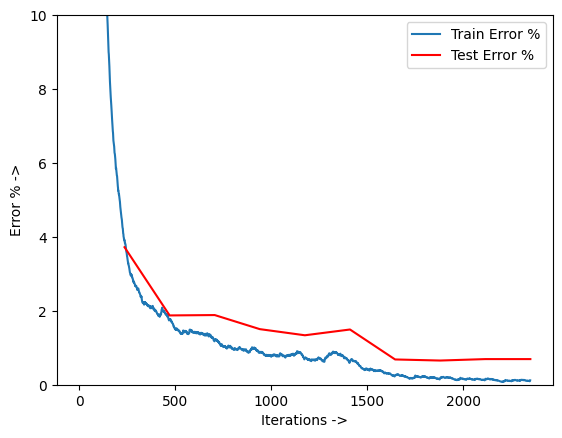

In [17]:
import numpy as np
plt.plot(smooth(all_train_losses, 0.99), label='Train Loss')
steps_per_epoch = len(train_dataloader)
test_iterations = [steps_per_epoch*(i+1) for i in range(epoch)]
plt.plot(test_iterations, all_test_losses, label='Test Loss', color='red')
plt.ylim([0, 0.2])
plt.xlabel('Iterations ->')
plt.ylabel('Loss ->')
plt.legend()
plt.show()

all_train_error = 100 - np.array(all_train_accuracy)
all_test_error = 100 - np.array(all_test_accuracy)
plt.plot(smooth(all_train_error, 0.98), label='Train Error %')
plt.plot(test_iterations, all_test_error, label='Test Error %', color='red')
plt.xlabel('Iterations ->')
plt.ylabel('Error % ->')
plt.ylim([0, 10])
plt.legend()
plt.show()

In [15]:
from torchinfo import summary
summary(model, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 16, 16]         3,136
├─MaxPool2d: 1-2                         [256, 64, 8, 8]           --
├─ModuleList: 1-3                        --                        --
│    └─ResidualBlock: 2-1                [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│    └─ResidualBlock: 2-2                [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-7                  [256, 64, 8, 8]           36,86